<a href="https://colab.research.google.com/github/chulminkim86/2019-1.-ManagementAndDatabase/blob/master/%5B%EA%B0%90%EC%84%B1%EA%B2%BD%ED%97%98%EB%94%94%EC%9E%90%EC%9D%B8%5DWord_Cloud_Ver2_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ⅰ. 분석에 필요한 라이브러리 설치
- 분석에 필요한 라이브러리들을 설치합니다. 
    - 설치 후 Colab 런타임 재시작이 필요한 라이브러리가 있습니다.
    - 설치 후 단순히 import 명령어로 호출하면 되는 라이브러리가 있습니다. 
    - 이런식으로 편집, 또는 구체적인 의미를 전달할 수 있게 합니다. 

### 첫번째 셀을 실행하고나서 __런타임 - 런타임 다시시작__을 눌러줍니다. (런타임 재시작)  
### 런타임이 재시작하고나면 두 번째 셀을 다시 실행합니다. (셀 실행)
### 다음 셀부터는 정상적으로 진행하면 됩니다. 

In [ ]:
# Colab에 Mecab 설치 (약 6분 소요) # 설치 후 런타임(커널) 재시작 필요 (약 33초)
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

#그래프에 한글 표시하기 #코드 실행 후 런타임(커널) 재시작 필요
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

#한국어 분석을 위한 패키지 설치 
!pip install konlpy
!pip install pyLDAvis 
!pip install numpy==1.19.5

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

---
##### 여기서부터는 런타임 재시작을 하지 않습니다. 
##### Shift+enter로 셀을 실행시켜보세요. 
---

In [ ]:
#기본 라이브러리 호출(Import)하기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#형태소 분석기 Konlpy 불러오기 
from konlpy.tag import Twitter; t = Twitter()
from konlpy.tag import Mecab
twitter = Twitter()

#워드클라우드 만들기 
from nltk import Text, FreqDist
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

#토픽모델링 라이브러리 사용
from gensim.corpora import Dictionary
from gensim import corpora, models, similarities, downloader
import gensim
import pyLDAvis.gensim_models
import pyLDAvis

---
# Ⅱ. 데이터 분석하기
- 우리들은 이제부터 텍스트마이닝을 할 예정입니다. 
- 가장 먼저 감성분석을 위한 사전학습을 수행할거에요. 
- 학습 이후 여러분들이 수집한 데이터를 투입하고 분석하도록 하겠습니다.
---

##1. (사전학습) 데이터 수집

In [ ]:
#사전학습에 사용할 학습데이터를 서버에서 다운받습니다.  
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

#다운받은 학습데이터를 정리하고, 전체 리뷰 개수와 샘플을 살펴봅니다. 
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) 
total_data[:5]

- ratings는 고객이 남긴 별점입니다. 이중 __1점과 2점, 3점은 부정적인 감정__, __4점과 5점은 긍정적인 감정__으로 전제하고 학습하도록 하겠습니다. 

## 2. (사전학습) 데이터 전처리

In [ ]:
#1점과 2점, 3점에는 0(부정), 4점과 5점은 1(긍정)로 레이블을 붙여줍니다. 
total_data['label'] = np.select([total_data["ratings"] > 3], [1], default=0)
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거

#레이블이 붙은 학습 데이터를 사전학습을 위해 트레이닝 데이터와 테스트 데이터로 구분합니다. 
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)

# 한글과 공백을 제외하고 모두 제거_traing data
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

# 한글과 공백을 제외하고 모두 제거_test data
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

In [ ]:
#KoNLpy 중 Mecab tag를 이용해 코퍼스(Courpus)를 만들어줍니다. 
mecab = Mecab()

#불용어 사전을 만들어줍니다. 
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

#트레이닝과 테스트 데이터를 대상으로 각각 불용어를 제거합니다. 
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

#부정적인 데이터와 긍정적인 데이터를 구분합니다. 
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

#3. 사전학습 분류 모델 생성

In [ ]:
#사전학습 모델에 사용할 데이터를 최종적으로 확정합니다. 
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

vocab_size = total_cnt - rare_cnt + 2

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
#사전학습에 사용할 파이썬 라이브러리는 Keras를 호출합니다. 
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#분류 모델 생성 및 학습 수행
X_train = pad_sequences(X_train, maxlen = 80)
X_test = pad_sequences(X_test, maxlen = 80)
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

## 4. 리뷰의 긍정/부정 감성을 도출하는 함수 __'sentiment_predic'__ 만들기 

In [ ]:
#함수 만들기
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = 80) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
#분석하고 싶은 리뷰를 입력해봅니다. 
word = input("분석하고 싶은 리뷰를 적어주세요: ")
sentiment_predict(word)

---
#이제부터 각 팀이 수집한 데이터를 투입하고 분석을 해봅시다!
---

## 1. 분석할 텍스트 데이터 불러오기
- 분석할 데이터를 불러옵니다. 
    - 여러분들이 수집한 데이터(csv형식)를 사용합니다.   
    - 수집한 데이터 이름은 가급적이면 영어로 작성해주세요. 
    - 수집한 데이터를 업로드 한 후 __파일이름__을 맞춰줘야합니다.   
① 왼쪽에 보이는 파일 아이콘fig1.png을 클릭하면 열리는 창에 여러분들의 데이터를 드래그앤드랍(Drag and Drop)으로 복사합니다.   
② 런타임 재활용 관련 안내창이 뜨면, 확인을 누릅니다.  
 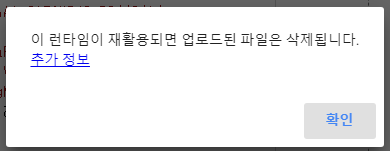



In [ ]:
#텍스트 데이터를 불러와서 'text'라는 이름의 변수로 저장합니다. 
#지금은 "naver.csv"로 작성되어 있는데, 여러분이 수집한 리뷰 데이터를 사용할 때는 파일 이름을 맞춰줘야 합니다. 
text = pd.read_csv("/content/naver.csv", encoding='utf-8')

#저장된 'text'변수 중 필요한 정보(고객리뷰)만을 골라내 확인해봅니다. 
#아래 보이는 표에서 리뷰가 적혀 있는 열 이름은 '0.1'입니다. 
text.head()

,Unnamed: 0,0,0.1
0,0,19.09.28,"💚닥터자르트 시카페어 크림💚(50ml, 48000원)⠀닥터자르트 시카페어 크림은 피..."
1,1,19.09.27,화이트&그린 조합으로 깔끔하고 화사한 패키지입니다.지우고 싶은 고민 부위까지 케어하...
2,2,19.09.28,"요즘 미세먼지, 환절기, 일교차로 인해 피부가 자극을 받고 극도로 예민해지고 있죠!..."
3,3,19.09.20,택배 상자 받자마자 포장 때문에 기분이 더 좋았어요!!특히 안쪽에는 시카크림인 만큼...
4,4,21.03.10,"우선, 제 피부타입은초초민감성+건성..이고마스크로 인해서 양쪽 볼+턱에여드름이랑 접..."


In [ ]:
#text뒤에 적혀 있는 ['0.1']은 열 이름입니다. 
#열 이름을 확인하고, 해당 열 이름을 지정해줍니다. 
review = text['0.1'] #0.1이 아닌 다른 열이름이라면 해당 열이름을 적어줍니다. 
review

0       💚닥터자르트 시카페어 크림💚(50ml, 48000원)⠀닥터자르트 시카페어 크림은 피...
1       화이트&그린 조합으로 깔끔하고 화사한 패키지입니다.지우고 싶은 고민 부위까지 케어하...
2       요즘 미세먼지, 환절기, 일교차로 인해 피부가 자극을 받고 극도로 예민해지고 있죠!...
3       택배 상자 받자마자 포장 때문에 기분이 더 좋았어요!!특히 안쪽에는 시카크림인 만큼...
4       우선, 제 피부타입은초초민감성+건성..이고마스크로 인해서 양쪽 볼+턱에여드름이랑 접...
                              ...                        
8705                                   싸고 배송도 빠르고 ㅋㅋ대만족^^
8706    하리보 젤리는 센스인가요?? ㅎㅎ기분좋게 잘받았습니다 배송도 빠르고 제품도 잘사용하...
8707    상호대로 정말 친절하십니다^^ 직원분들도 아주 친절하시구요. 배송도 빨라서 만족합니...
8708                       직원분들도 친절하시구 배송도 빠르고 아주 만족해요~^^
8709    닥터자르트 시카케어 나온다는 소식을 듣고 일본에서 해외배송 시켜서 잘 바르고 잇어요...
Name: 0.1, Length: 8710, dtype: object

##2. 텍스트 데이터 분석을 위한 전처리(preprocesse)수행하기
- 수집한 텍스트 데이터는 특수기호나, 오타 때문에 지저분한 상태입니다.
- 텍스트 데이터를 분석하기 위해 단어를 숫자화(임베딩, 토크나이징)해야 합니다.
- 이 모든 과정을 __텍스트 데이터 전처리__라고 합니다. 

In [ ]:
#수집된 고객 리뷰 데이터를 파이썬 자료구조인 리스트(list)로 바꿉니다. 
review_List = review.tolist()

#리스트로 바뀐 데이터를 결합해 변수 'review'에 덧씌워줍니다. 
review_List = '\n'.join(review_List)

#변수 'review'에 저장된 텍스트를 개별 단어(noun)수준으로 쪼개 새로운 변수 'token_text'에 저장합니다. 
token_text = t.nouns(review_List)

# 3. 텍스트 데이터 상태분석(EDA)
- 이제 고객 리뷰데이터는 각 개별단어 수준으로 쪼개져있습니다. 
- 각 단어들의 빈도 수 등 현황을 살펴보겠습니다. 

In [ ]:
#KoNLpy 중 Text tag를 이용해 코퍼스(Courpus)를 만들어줍니다. 
word_review = Text(token_text)

#코퍼스에 포함된 각 단어들의 빈도수를 계산합니다
fd_ko = FreqDist(word_review)
print("총",fd_ko.N(),"개 단어가 사용되었습니다.")

In [ ]:
#가장 많이 사용된 상위 10개 단어를 살펴봅니다. 
fd_ko.most_common(30)

In [ ]:
#특정 단어가 몇 번이나 사용되었는지 살펴봅니다. 
word = input("어떤 단어를 찾아볼까요?")
print('{}'.format(fd_ko[word]),'번 사용되었습니다.')

In [ ]:
#사용된 단어 중 상위 50개 단어의 빈도를 그래프로 나타내보겠습니다. 
plt.figure(figsize=(20, 5)) #그래프 크기를 설정합니다. 
fd_ko.plot(50) #단어 갯수를 정의합니다. 
plt.show() #그래프를 만들어줍니다. 

생성된 그래프를 보면, 의미없는 단어들이 눈에 보입니다.   
이런 단어들을 불용어(不용어)라고 합니다.  
불용어는 제거하는 것이 텍스트 분석 성능을 향상시키는데 유리합니다. 

In [ ]:
#불용어 사전을 만들어줍니다. 
stop_words = ['것','거','더','트','때','카','또','늘','저','날','이','제', "끝"]

#만들어진 불용어 사전에 속한 단어들을 기존 코퍼스에서 제거합니다. 
clean_word_review = [each_word for each_word in word_review if each_word not in stop_words]

In [ ]:
#불용어를 제거한 현황을 살펴봅니다. 
print("불용어 제거 전에는 총",fd_ko.N(),"개 단어가 사용되었습니다.")
print("불용어 제거 후에는 총",FreqDist(clean_word_review).N(),"개 단어가 사용되었습니다.")
print("총", fd_ko.N()-FreqDist(clean_word_review).N(), '개가 제거되었습니다.')

# 4. 워드클라우드 만들기
- 워드클라우드는 많이 사용한 단어를 그림으로 표현한 것입니다. 
- 워드클라우드를 한번 그려보도록 하겠습니다.

In [ ]:
#워드클라우드 만들기 
clean_word_review = Text(clean_word_review)
data = clean_word_review.vocab().most_common(200)
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                     relative_scaling = 0.5,
                     background_color='white',
                     ).generate_from_frequencies(dict(data))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Ⅲ. 감성분석(sentiment Analysis) 
- 감성분석은 사용한 단어에 반영되어 있는 긍/부정 등 감성을 도출하는 분석을 의미합니다. 
- 단어에 담겨 있는 긍정/부정 감성을 분류하는 다양한 방법이 있지만, 우리들은 네이버 쇼핑몰 리뷰 데이터를 이용해 감성을 __사전학습__하도록 하겠습니다. 

## 5. 수집했었던 데이터의 긍정/부정 감성 분류하기

In [ ]:
# 만들어둔 함수를 응용해 내가 수집한 댓글 분류하기
positive_reviews = [] #긍정
negative_reviews = [] #부정

def sentiment_classification(sentence):
  new_sentence = sentence
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = 80) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    positive_reviews.append(sentence)
  else:
    negative_reviews.append(sentence)

In [ ]:
#분류 작업 수행(약 6분 소요)
for i in range(len(review)):
    sentiment_classification(review[i])
print('긍정적인 리뷰는 총',len(positive_reviews),'개입니다.')
print('부정적인 리뷰는 총',len(negative_reviews),'개입니다.')

In [ ]:
#부정적인 감성 리뷰 출력
negative_review = pd.DataFrame(negative_reviews)
negative_review

In [ ]:
#긍정적인 감성 리뷰 출력
positive_review = pd.DataFrame(positive_reviews)
positive_review

In [ ]:
#각 감성 리뷰 CSV로 저장
positive_review.to_csv("/content/Positive.csv", encoding="utf-8")
negative_review.to_csv("/content/Negative.csv", encoding="utf-8")

# Ⅳ. 토픽모델링(Topic Modeling) 
- 감성분석은 주어진 문서(Corpus)를 대상으로 어떤 주제들이 존재하는지 밝혀내는 분석기법입니다. 
- 전체 문서를 구성하는 각 세부단어들이 보이는 확률분포를 파악하고, 각 토픽들을 발견하게 됩니다.
- 분석자는 토픽의 갯수, 구성 단어 갯수 등을 파라미터(Parameter)를 지정해 조정할 수 있으나, 별도의 작업을 통해 최적의 파라미터를 입력하는 것이 일반적입니다.  

## 1. 사용 데이터 정의
- 토픽모델링을 수행할 데이터를 정의합니다. 
- 지금 우리들은 최초로 입력한 데이터(ex:Naver.csv)에 대한 긍정/부정적 리뷰 데이터를 갖고 있습니다. 
- 각각 토픽모델링을 수행할 예정이므로 우리는 총 두번의 토픽모델링을 수행합니다. 

In [ ]:
#토픽모델링 데이터 정의
pos_data = positive_review
nega_data = negative_review

#각 데이터 컬럼명 변경
pos_data.columns = ['reviews']
nega_data.columns = ['reviews']

## 2. 데이터 전처리
- 토픽모델링을 수행하기 위해 데이터 전처리를 수행합니다. 
- 감성분석에서 이미 한 차례 했지만, 보다 명확한 토픽을 골라내기 위해 중복값 제거 등을 수행합니다. 

In [ ]:
#데이터 프레임의 'review' 열의 값들을 str 형식으로 바꾸기
pos_data['reviews'] = pos_data['reviews'].astype(str)
nega_data['reviews'] = nega_data['reviews'].astype(str)

#review 열을 기준으로 중복된 데이터를 삭제
pos_data.drop_duplicates(subset=['reviews'], inplace=True)
nega_data.drop_duplicates(subset=['reviews'], inplace=True)

#한글이 아니면 빈 문자열로 바꾸기, 정규표현식 사용
pos_data['reviews'] = pos_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ', regex=True)
nega_data['reviews'] = nega_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ', regex=True)

#빈 문자열을 널 값(NAN) 값으로 바꾸기
pos_data = pos_data.replace({'': np.nan})
pos_data = pos_data.replace(r'^\s*$', None, regex=True)
nega_data = nega_data.replace({'': np.nan})
nega_data = nega_data.replace(r'^\s*$', None, regex=True)

#널 값(NAN)이 있는 행은 삭제
pos_data.dropna(how='any', inplace=True)
nega_data.dropna(how='any', inplace=True)

#인덱스 재정렬
pos_data = pos_data.reset_index (drop = True)
nega_data = nega_data.reset_index (drop = True)

#텍스트 데이터를 리스트 형태로 변환
pos_data_list = pos_data['reviews'].values.tolist()
nega_data_list = nega_data['reviews'].values.tolist()

In [ ]:
#생성된 리스트를 요소별로(댓글 하나) 가져와서 명사만 추출한 후 리스트로 저장
pos_data_word=[] 
nega_data_word=[] 

mecab = Mecab() #Konlpy 중 okt 사용 (형태소분석기), 향후 다양한 분석기로 실험 

#긍정 댓글 처리
for i in range(len(pos_data_list)):
    try:
        pos_data_word.append(mecab.nouns(pos_data_list[i]))
    except Exception as e:
        continue

#부정 댓글 처리
for i in range(len(nega_data_list)):
    try:
        nega_data_word.append(mecab.nouns(nega_data_list[i]))
    except Exception as e:
        continue

#만들어진 명사 리스트에서 한글자 단어 삭제
pos_dic = []
nega_dic = []

for n in range(len(pos_data_word)):
  for i in range(len(pos_data_word[n])):
    if len(pos_data_word[n][i]) >1:
      pos_dic.append([pos_data_word[n][i]])

for n in range(len(nega_data_word)):
  for i in range(len(nega_data_word[n])):
    if len(nega_data_word[n][i]) >1:
      nega_dic.append([nega_data_word[n][i]])

## 3. 토픽모델링을 위한 기본 파라미터 설정

In [ ]:
#Word Dictionary 만들기
pos_dictionary = corpora.Dictionary(pos_dic)
nega_dictionary = corpora.Dictionary(nega_dic)

#Corpus 만들기
pos_texts = pos_dic
nega_texts = nega_dic

#(TDF)Term Document Frequency 만들기
pos_corpus = [pos_dictionary.doc2bow(text) for text in pos_texts]
nega_corpus = [nega_dictionary.doc2bow(text) for text in nega_texts]

In [ ]:
#LDA model 생성(gensim 사용) 약 1분 소요
topic_num = int(input("몇개 토픽을 생성할까요? "))
word_num = int(input("토픽 당 몇개 단어를 출력할까요? "))

pos_lda_model = gensim.models.ldamodel.LdaModel(corpus=pos_corpus, #활용 Corpus
                                            id2word=pos_dictionary, #활용 단어벡터
                                            num_topics=topic_num, #생성 토픽수
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
nega_lda_model = gensim.models.ldamodel.LdaModel(corpus=nega_corpus, #활용 Corpus
                                            id2word=nega_dictionary, #활용 단어벡터
                                            num_topics=topic_num, #생성 토픽수
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [ ]:
#긍정적인 리뷰 토픽모델링 결과 Table 생성
word_dict = {}
num_topic = topic_num
for i in range(num_topic):
  words = pos_lda_model.show_topic(i, topn = word_num) #topn == 단어개수
  word_dict['Pos_Topic #'+'{:02d}'.format(i+1)] = [i[0] for i in words]

pd.DataFrame(word_dict)

In [ ]:
#부정적인 리뷰 토픽모델링 결과 Table 생성
word_dict = {}
num_topic = topic_num
for i in range(num_topic):
  words = nega_lda_model.show_topic(i, topn = word_num) #topn == 단어개수
  word_dict['Nega_Topic #'+'{:02d}'.format(i+1)] = [i[0] for i in words]

pd.DataFrame(word_dict)

In [ ]:
#긍정적 토픽모델링 결과 시각화
#각 원은 토픽 1개를 의미
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(pos_lda_model, pos_corpus, pos_dictionary) 
vis

In [ ]:
#부정적 토픽모델링 결과 시각화
#각 원은 토픽 1개를 의미
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(nega_lda_model, nega_corpus, nega_dictionary) 
vis